# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf
from IPython.display import display
import re

Using TensorFlow backend.


# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    #'Fièvre': '/m/0cjf0',
    #'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    #'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    #'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

In [4]:
date_begin = "2020-02-01"

def log_values(df, columns: list = None, base: int = 10, inf_value='drop'):
    """
    add log values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :param inf_value: value to give for the inf created by the log. Can be integer or 'drop' (dropping the values)
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
        
    if inf_value == 'drop':
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    else: #inf_value should be an integer
        df = df.replace([np.inf, -np.inf], inf_value)
    return df
        

def pct_values(df, columns: list = None, add_one: bool = False):
    """
    add percentage values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param add_one: if True, the percentage of difference add a value of 100% to each percentage
    :return dataframe with pct change values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_pct" for name in columns]
    df[new_columns] = df[columns].pct_change()
    if add_one:
        df[new_columns] = df[new_columns] + 1
    return df
    

def create_dataframe_hospi(hospi_france_tot, hospi_france_new, hospi_belgium, department_france, geo, 
                           new_hosp_in=True, tot_hosp=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    :param hospi_france_tot: url/path for the total french hospitalisations csv
    :param hospi_france_new: url/path for the new french hospitalisations csv
    :param hospi_belgium: url/path for the belgian hospitalisations csv
    :param department_france: url/path for the mapping of french department to regions
    :param geo: geocode of the region that should be incuded in the final dict
    :param new_hosp_in: if True, includes the new daily hospitalisations (inwards)
    :param tot_hosp: if True, includes the total hospitalisations
    :return dict of {geocode: hosp_df} where hosp is hospitalisation dataframe of each geocode
    """
    columns_be = {}  # only for belgium, not for france (the files are handled differently)
    data_columns = []  # final data columns that will be present in the df
    if new_hosp_in:
        columns_be['NEW_IN'] = 'sum'
        data_columns.append("NEW_HOSP")
    if tot_hosp:
        columns_be['TOTAL_IN'] = 'sum'
        data_columns.append("TOT_HOSP")
    if len(columns_be) == 0:
        raise Exception("no hospitalisation column specified")
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    
    # French data: total hospitalisation
    if tot_hosp:
        hospitalisations = pd.read_csv(hospi_france_tot, sep=";", parse_dates=['jour'], date_parser=date_parser)
        hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
        data_fr_tot = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"], as_index=False).agg({"hosp": "sum"})
    
    # French data: new hospitalisation
    if new_hosp_in:
        hospitalisations = pd.read_csv(hospi_france_new, sep=";", parse_dates=['jour'], date_parser=date_parser)
        data_fr_new = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"],as_index=False).agg({"incid_hosp": "sum"})
    
    # merge the french data
    common_columns = ["regionTrends", "jour"]
    if tot_hosp and new_hosp_in:
        data_fr = data_fr_tot.merge(data_fr_new, how='outer',left_on=common_columns, right_on=common_columns).fillna(0)
    elif tot_hosp:
        data_fr = data_fr_tot
    elif new_hosp_in:
        data_fr = data_fr_new
    data_fr = data_fr.rename(columns={"jour": "DATE", "regionTrends": "LOC", "hosp": "TOT_HOSP", "incid_hosp": "NEW_HOSP"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium, parse_dates=['DATE'], date_parser=date_parser).groupby(
        ["DATE"], as_index=False).agg(columns_be).rename(
        columns={"TOTAL_IN": "TOT_HOSP", "NEW_IN": "NEW_HOSP"})
    data_be["LOC"] = "BE"
    
    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    add_entry = [0 for i in range(len(data_columns))]  # each missing entry consist of zero for each data col
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, *add_entry])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", *data_columns]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[(full_data.index.get_level_values('LOC') == k) & 
                                     (full_data.index.get_level_values('DATE') <= highest_date)]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    if len(renaming)==0:
        return {k: pd.DataFrame() for k in geocodes}
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [5]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france_new = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"

# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                  url_department_france, geocodes)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    df_hospi[k] = log_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = pct_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = df_hospi[k][list_hosp_features]
    
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """

# Preprocess data

## Normalization [0,1]

In [6]:
df_hospi['BE']

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-16  1909.285714
    2021-01-17  1909.428571
    2021-01-18  1914.142857
    2021-01-19  1920.857143
    2021-01-20  1930.857143

[315 rows x 1 columns]

In [7]:
inverse_param = {}
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    if len(list_topics) !=0:
        to_scale = [name for name in df_trends[k].columns if name not in unscaled]
        df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=to_scale, index=df_trends[k].index)
    # store a tuple of min,max
    inverse_param[k] = (df_hospi[k][target].min(), df_hospi[k][target].max())
    to_scale = [name for name in df_hospi[k].columns if name not in unscaled]
    df_hospi[k][to_scale] = pd.DataFrame(scaler.fit_transform(df_hospi[k][to_scale].values), columns=to_scale, index=df_hospi[k].index)
# store the inverse transform for the target only
inverse_transform = lambda df,k: df[[target]] * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0] 
inverse_transform_fun = lambda val,k: val * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0]
df_hospi['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-12  0.000000
    2020-03-13  0.007370
    2020-03-14  0.017270
    2020-03-15  0.030217
    2020-03-16  0.047029
...                  ...
    2021-01-16  0.260921
    2021-01-17  0.260941
    2021-01-18  0.261598
    2021-01-19  0.262534
    2021-01-20  0.263928

[315 rows x 1 columns]

In [8]:
inverse_transform(df_hospi['BE'], 'BE')

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-16  1909.285714
    2021-01-17  1909.428571
    2021-01-18  1914.142857
    2021-01-19  1920.857143
    2021-01-20  1930.857143

[315 rows x 1 columns]

Map to the sum of hospitalizations

In [9]:
def mapper(data, loc):
    allowed_map = ['TOT_HOSP']  # implemented mapping
    if target == 'TOT_HOSP':
        return [inverse_transform_fun(val,loc) for val in data]
    else:
        raise Exception(f"cannot map {target} to TOT_HOSP")
    
    



## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [10]:
n_forecast = 3  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date

## Add lag

In [11]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [12]:
def timeseries_add_lag(data, lag, dropna=True):
    #Adds lagged values to dataframe
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


if len(list_topics) !=0:
    merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
else:
    merged_df = {k: df_hospi[k] for k in geocodes}
    
# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

In [13]:
merged_df['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-16  0.030217
    2020-03-17  0.047029
    2020-03-18  0.068960
    2020-03-19  0.096528
    2020-03-20  0.124016
...                  ...
    2021-01-16  0.260921
    2021-01-17  0.260921
    2021-01-18  0.260941
    2021-01-19  0.261598
    2021-01-20  0.262534

[311 rows x 1 columns]

In [14]:
lagged_df['BE']

TOT_HOSP(t-13)  TOT_HOSP(t-12)  TOT_HOSP(t-11)  \
LOC DATE                                                         
BE  2020-03-29        0.030217        0.047029        0.068960   
    2020-03-30        0.047029        0.068960        0.096528   
    2020-03-31        0.068960        0.096528        0.124016   
    2020-04-01        0.096528        0.124016        0.154154   
    2020-04-02        0.124016        0.154154        0.186881   
...                        ...             ...             ...   
    2021-01-16        0.298747        0.293628        0.290262   
    2021-01-17        0.293628        0.290262        0.288568   
    2021-01-18        0.290262        0.288568        0.284684   
    2021-01-19        0.288568        0.284684        0.280103   
    2021-01-20        0.284684        0.280103        0.275999   

                TOT_HOSP(t-10)  TOT_HOSP(t-9)  TOT_HOSP(t-8)  TOT_HOSP(t-7)  \
LOC DATE                                                                      
BE  2020-03-29        0.096528       0.124016       0.154154       0.186881   
    2020-03-30        0.124016       0.154154       0.186881       0.228134   
    2020-03-31        0.154154       0.186881       0.228134       0.272613   
    2020-04-01        0.186881       0.228134       0.272613       0.323387   
    2020-04-02        0.228134       0.272613       0.323387       0.377268   
...                        ...            ...            ...            ...   
    2021-01-16        0.288568       0.284684       0.280103       0.275999   
    2021-01-17        0.284684       0.280103       0.275999       0.272613   
    2021-01-18        0.280103       0.275999       0.272613       0.269844   
    2021-01-19        0.275999       0.272613       0.269844       0.267653   
    2021-01-20        0.272613       0.269844       0.267653       0.265263   

                TOT_HOSP(t-6)  TOT_HOSP(t-5)  TOT_HOSP(t-4)  TOT_HOSP(t-3)  \
LOC DATE                                                                     
BE  2020-03-29       0.228134       0.272613       0.323387       0.377268   
    2020-03-30       0.272613       0.323387       0.377268       0.433719   
    2020-03-31       0.323387       0.377268       0.433719       0.493755   
    2020-04-01       0.377268       0.433719       0.493755       0.550505   
    2020-04-02       0.433719       0.493755       0.550505       0.600283   
...                       ...            ...            ...            ...   
    2021-01-16       0.272613       0.269844       0.267653       0.265263   
    2021-01-17       0.269844       0.267653       0.265263       0.263092   
    2021-01-18       0.267653       0.265263       0.263092       0.261837   
    2021-01-19       0.265263       0.263092       0.261837       0.260921   
    2021-01-20       0.263092       0.261837       0.260921       0.260921   

                TOT_HOSP(t-2)  TOT_HOSP(t-1)  TOT_HOSP  
LOC DATE                                                
BE  2020-03-29       0.433719       0.493755  0.550505  
    2020-03-30       0.493755       0.550505  0.600283  
    2020-03-31       0.550505       0.600283  0.646216  
    2020-04-01       0.600283       0.646216  0.683326  
    2020-04-02       0.646216       0.683326  0.712049  
...                       ...            ...       ...  
    2021-01-16       0.263092       0.261837  0.260921  
    2021-01-17       0.261837       0.260921  0.260921  
    2021-01-18       0.260921       0.260921  0.260941  
    2021-01-19       0.260921       0.260941  0.261598  
    2021-01-20       0.260941       0.261598  0.262534  

[298 rows x 14 columns]

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [15]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(298, 14, 1)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [16]:
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

0

In [17]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [18]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 3, 31), datetime.date(2020, 4, 1), datetime.date(2020, 4, 2)], [datetime.date(2020, 4, 1), datetime.date(2020, 4, 2), datetime.date(2020, 4, 3)], [datetime.date(2020, 4, 2), datetime.date(2020, 4, 3), datetime.date(2020, 4, 4)], [datetime.date(2020, 4, 3), datetime.date(2020, 4, 4), datetime.date(2020, 4, 5)], [datetime.date(2020, 4, 4), datetime.date(2020, 4, 5), datetime.date(2020, 4, 6)], [datetime.date(2020, 4, 5), datetime.date(2020, 4, 6), datetime.date(2020, 4, 7)], [datetime.date(2020, 4, 6), datetime.date(2020, 4, 7), datetime.date(2020, 4, 8)], [datetime.date(2020, 4, 7), datetime.date(2020, 4, 8), datetime.date(2020, 4, 9)], [datetime.date(2020, 4, 8), datetime.date(2020, 4, 9), datetime.date(2020, 4, 10)], [datetime.date(2020, 4, 9), datetime.date(2020, 4, 10), datetime.date(2020, 4, 11)], [datetime.date(2020, 4, 10), datetime.date(2020, 4, 11), datetime.date(2020, 4, 12)], [datetime.date(2020, 4, 11), datetime.date(2020, 4, 12), datetime.dat

## Split into train - test set

In [19]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(294, 14, 1)
(294, 3, 1)


In [20]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 3)


## Real-time prediction

In [45]:
fit_first_days = 280  # use 'fit_first_days' days for the first fit
fit_steps_days = 30  # every 'fit_steps_days' days, do a new fit of the data
epochs = 2800 # epochs used to train the model

In [22]:
def get_x_dates(idx):
    return np.array(x_dates)[idx]
    
def get_y_dates(idx, horizon=1):
    """
    return the target dates on the corresponding indexes
    :param horizon: int corresponding to the horizon of dates. Can be
        - a value in [1, n_forecast] corresponding to the given horizon date (1: tomorrow, 2: in two days, ...)
        - None gives all target dates in [1, n_forecast]
    """
    result_dates = np.array(y_dates)[idx]
    if horizon is not None:
        result_dates = result_dates[:,horizon-1]
    return result_dates

def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [23]:
def plot_prediction_vs_actual(predicted, idx, loc, horizon=1, show_fit=50, mode=0, map_to_hosp=True):
    """
    
    :param loc: location of the prediction
    :param predicted: value predicted
    :param idx: index of the y_values used
    :param horizon: horizon that must be plot
    :param show_fit: max number of days of fit that must be plot
    :param mode: used when horizon > 1. tell how to plot with respect to the horizons
        - mode = 0: plot one graph for all values for this specific horizon
        - mode = 1: plot one graph for all horizon in [1, horizon]
    :param map_to_hosp: if True, show the plot of predictions mapped to the total number of hosp
    """
    target_expected = data_value_region(idx, loc)[1]
    
    if mode == 0:
        horizon_range = range(horizon, horizon+1)
    elif mode == 1:
        horizon_range = range(1, horizon+1)
        
    for horizon in horizon_range:
        fig = plt.figure(figsize=(6,3))
        if show_fit > 0:
            fit_idx = [idx[0]-i for i in range(show_fit, 0, -1) if idx[0]-i >= 0]
            fit_dates = get_y_dates(fit_idx, horizon=horizon)
            # get all predictions of corresponding horizon that were used to fit the model
            fit_values = data_value_region(fit_idx, loc)[1][:,horizon-1].reshape(-1)
            if map_to_hosp:
                fit_values = mapper(fit_values, loc)
            plt.plot(fit_dates, fit_values, label="fitting used")

        prediction_dates = get_y_dates(idx, horizon=horizon)
        if map_to_hosp:
            target_expected_map = mapper(target_expected[:,horizon-1].reshape(-1), loc)
        else:
            target_expected_map = target_expected[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, target_expected_map, marker=".", label="True value")

        if map_to_hosp:
            prediction = mapper(predicted[:,horizon-1].reshape(-1), loc)
        else:
            prediction = predicted[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, prediction, marker='.', label=f"prediction horizon {horizon}")

        ax = fig.axes[0]
        # set locator
        if len(idx) + show_fit > 50:  # monthly locator
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        else:  # weekly locator
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.grid()
        if mode != 0:
            plt.show()
    

In [24]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_idx = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(geocodes), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_idx.append(predict_idx)
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

Epoch 1/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1834
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1037
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0292
Epoch 5/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0188
Epoch 6/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 7/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 8/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 9/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 10/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0103


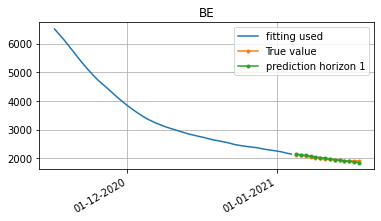

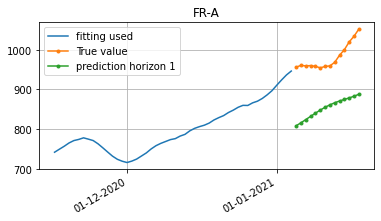

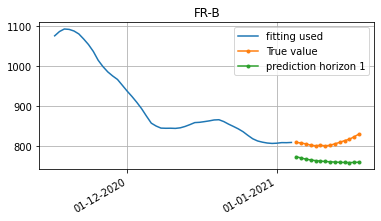

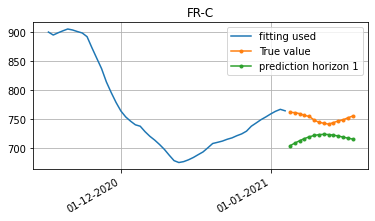

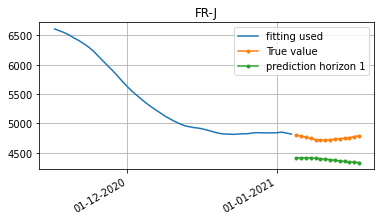

In [25]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target_expected = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        plot_prediction_vs_actual(prediction, prediction_idx[i], loc)
        plt.title(loc)

# Comparison between several models

In [26]:
end_train = "2020-09-15"  # dates with respect to x, included
end_valid = "2020-11-25"
end_test = "2020-12-31"

date_f = "%Y-%m-%d"
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(test_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [46]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 3)


In [47]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 1s 113ms/step - loss: 0.1040 - val_loss: 0.1593
Epoch 2/2800
5/5 [==============================] - 0s 16ms/step - loss: 0.0605 - val_loss: 0.0923
Epoch 3/2800
5/5 [==============================] - 0s 24ms/step - loss: 0.0297 - val_loss: 0.0397
Epoch 4/2800
5/5 [==============================] - 0s 14ms/step - loss: 0.0191 - val_loss: 0.0183
Epoch 5/2800
5/5 [==============================] - 0s 17ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 6/2800
5/5 [==============================] - 0s 14ms/step - loss: 0.0122 - val_loss: 0.0272
Epoch 7/2800
5/5 [==============================] - 0s 17ms/step - loss: 0.0102 - val_loss: 0.0292
Epoch 8/2800
5/5 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0226
Epoch 9/2800
5/5 [==============================] - 0s 18ms/step - loss: 0.0073 - val_loss: 0.0198
Epoch 10/2800
5/5 [==============================] - 0s 31ms/step - loss: 0.0076 - val_loss: 0.0226
Epoch 11

5/5 [==============================] - 0s 13ms/step - loss: 3.5646e-04 - val_loss: 0.0029
Epoch 82/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.5391e-04 - val_loss: 0.0029
Epoch 83/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.5134e-04 - val_loss: 0.0029
Epoch 84/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.4881e-04 - val_loss: 0.0029
Epoch 85/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.4643e-04 - val_loss: 0.0029
Epoch 86/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.4418e-04 - val_loss: 0.0029
Epoch 87/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.4196e-04 - val_loss: 0.0029
Epoch 88/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3973e-04 - val_loss: 0.0029
Epoch 89/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.3759e-04 - val_loss: 0.0029
Epoch 90/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.35

5/5 [==============================] - 0s 11ms/step - loss: 2.5898e-04 - val_loss: 0.0026
Epoch 160/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5834e-04 - val_loss: 0.0026
Epoch 161/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5774e-04 - val_loss: 0.0026
Epoch 162/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5711e-04 - val_loss: 0.0026
Epoch 163/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.5652e-04 - val_loss: 0.0026
Epoch 164/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5591e-04 - val_loss: 0.0026
Epoch 165/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5534e-04 - val_loss: 0.0026
Epoch 166/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.5473e-04 - val_loss: 0.0026
Epoch 167/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.5417e-04 - val_loss: 0.0026
Epoch 168/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 2.3321e-04 - val_loss: 0.0025
Epoch 238/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.2187e-04 - val_loss: 0.0024
Epoch 239/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.3560e-04 - val_loss: 0.0025
Epoch 240/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.2223e-04 - val_loss: 0.0024
Epoch 241/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.3861e-04 - val_loss: 0.0025
Epoch 242/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2305e-04 - val_loss: 0.0024
Epoch 243/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.4200e-04 - val_loss: 0.0025
Epoch 244/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2419e-04 - val_loss: 0.0024
Epoch 245/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.4514e-04 - val_loss: 0.0025
Epoch 246/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 1.9765e-04 - val_loss: 0.0022
Epoch 316/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9734e-04 - val_loss: 0.0022
Epoch 317/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9708e-04 - val_loss: 0.0022
Epoch 318/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9678e-04 - val_loss: 0.0022
Epoch 319/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9652e-04 - val_loss: 0.0022
Epoch 320/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9621e-04 - val_loss: 0.0022
Epoch 321/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9595e-04 - val_loss: 0.0022
Epoch 322/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9564e-04 - val_loss: 0.0022
Epoch 323/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9538e-04 - val_loss: 0.0022
Epoch 324/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 12ms/step - loss: 2.0794e-04 - val_loss: 0.0021
Epoch 394/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.8680e-04 - val_loss: 0.0020
Epoch 395/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.2077e-04 - val_loss: 0.0021
Epoch 396/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9535e-04 - val_loss: 0.0020
Epoch 397/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.3478e-04 - val_loss: 0.0022
Epoch 398/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.0403e-04 - val_loss: 0.0020
Epoch 399/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.4366e-04 - val_loss: 0.0022
Epoch 400/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.0689e-04 - val_loss: 0.0020
Epoch 401/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.3866e-04 - val_loss: 0.0022
Epoch 402/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 1.5374e-04 - val_loss: 0.0018
Epoch 472/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5348e-04 - val_loss: 0.0018
Epoch 473/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.5322e-04 - val_loss: 0.0018
Epoch 474/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.5297e-04 - val_loss: 0.0018
Epoch 475/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5271e-04 - val_loss: 0.0018
Epoch 476/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5245e-04 - val_loss: 0.0018
Epoch 477/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.5219e-04 - val_loss: 0.0018
Epoch 478/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5192e-04 - val_loss: 0.0018
Epoch 479/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5166e-04 - val_loss: 0.0018
Epoch 480/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 1.3292e-04 - val_loss: 0.0016
Epoch 550/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3262e-04 - val_loss: 0.0016
Epoch 551/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3238e-04 - val_loss: 0.0016
Epoch 552/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3207e-04 - val_loss: 0.0015
Epoch 553/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3184e-04 - val_loss: 0.0015
Epoch 554/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3152e-04 - val_loss: 0.0015
Epoch 555/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.3130e-04 - val_loss: 0.0015
Epoch 556/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3097e-04 - val_loss: 0.0015
Epoch 557/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3076e-04 - val_loss: 0.0015
Epoch 558/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 1.0893e-04 - val_loss: 0.0013
Epoch 628/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.0892e-04 - val_loss: 0.0013
Epoch 629/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.0861e-04 - val_loss: 0.0013
Epoch 630/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.0845e-04 - val_loss: 0.0013
Epoch 631/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.0828e-04 - val_loss: 0.0013
Epoch 632/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.0801e-04 - val_loss: 0.0013
Epoch 633/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.0788e-04 - val_loss: 0.0013
Epoch 634/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.0765e-04 - val_loss: 0.0013
Epoch 635/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.0747e-04 - val_loss: 0.0013
Epoch 636/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 9.3834e-05 - val_loss: 0.0011
Epoch 706/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.3644e-05 - val_loss: 0.0011
Epoch 707/2800
5/5 [==============================] - 0s 12ms/step - loss: 9.3454e-05 - val_loss: 0.0011
Epoch 708/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.3264e-05 - val_loss: 0.0011
Epoch 709/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.3075e-05 - val_loss: 0.0011
Epoch 710/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.2886e-05 - val_loss: 0.0011
Epoch 711/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.2698e-05 - val_loss: 0.0011
Epoch 712/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.2509e-05 - val_loss: 0.0011
Epoch 713/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.2322e-05 - val_loss: 0.0011
Epoch 714/2800
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 12ms/step - loss: 8.1100e-05 - val_loss: 9.0272e-04
Epoch 782/2800
5/5 [==============================] - 0s 11ms/step - loss: 8.0803e-05 - val_loss: 8.9972e-04
Epoch 783/2800
5/5 [==============================] - 0s 12ms/step - loss: 8.0837e-05 - val_loss: 8.9833e-04
Epoch 784/2800
5/5 [==============================] - 0s 11ms/step - loss: 8.0501e-05 - val_loss: 8.9516e-04
Epoch 785/2800
5/5 [==============================] - 0s 11ms/step - loss: 8.0582e-05 - val_loss: 8.9399e-04
Epoch 786/2800
5/5 [==============================] - 0s 12ms/step - loss: 8.0198e-05 - val_loss: 8.9062e-04
Epoch 787/2800
5/5 [==============================] - 0s 12ms/step - loss: 8.0337e-05 - val_loss: 8.8970e-04
Epoch 788/2800
5/5 [==============================] - 0s 11ms/step - loss: 7.9893e-05 - val_loss: 8.8607e-04
Epoch 789/2800
5/5 [==============================] - 0s 11ms/step - loss: 8.0104e-05 - val_loss: 8.8548e-04
Epoch 790/2800
5/5 [==============

5/5 [==============================] - 0s 11ms/step - loss: 8.6259e-05 - val_loss: 8.0064e-04
Epoch 857/2800
5/5 [==============================] - 0s 12ms/step - loss: 8.9410e-05 - val_loss: 8.1367e-04
Epoch 858/2800
5/5 [==============================] - 0s 15ms/step - loss: 9.1273e-05 - val_loss: 8.0384e-04
Epoch 859/2800
5/5 [==============================] - 0s 16ms/step - loss: 9.5208e-05 - val_loss: 8.2013e-04
Epoch 860/2800
5/5 [==============================] - 0s 16ms/step - loss: 9.7962e-05 - val_loss: 8.1067e-04
Epoch 861/2800
5/5 [==============================] - 0s 15ms/step - loss: 1.0284e-04 - val_loss: 8.3148e-04
Epoch 862/2800
5/5 [==============================] - 0s 16ms/step - loss: 1.0657e-04 - val_loss: 8.2280e-04
Epoch 863/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.1224e-04 - val_loss: 8.4904e-04
Epoch 864/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.1654e-04 - val_loss: 8.4113e-04
Epoch 865/2800
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 6.4068e-05 - val_loss: 6.6617e-04
Epoch 932/2800
5/5 [==============================] - 0s 13ms/step - loss: 6.4060e-05 - val_loss: 6.6445e-04
Epoch 933/2800
5/5 [==============================] - 0s 19ms/step - loss: 6.4051e-05 - val_loss: 6.6274e-04
Epoch 934/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.4041e-05 - val_loss: 6.6104e-04
Epoch 935/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.4030e-05 - val_loss: 6.5935e-04
Epoch 936/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.4018e-05 - val_loss: 6.5767e-04
Epoch 937/2800
5/5 [==============================] - 0s 16ms/step - loss: 6.4004e-05 - val_loss: 6.5599e-04
Epoch 938/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.3989e-05 - val_loss: 6.5432e-04
Epoch 939/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.3974e-05 - val_loss: 6.5266e-04
Epoch 940/2800
5/5 [==============

5/5 [==============================] - 0s 13ms/step - loss: 6.0623e-05 - val_loss: 5.5510e-04
Epoch 1007/2800
5/5 [==============================] - 0s 13ms/step - loss: 6.0560e-05 - val_loss: 5.5380e-04
Epoch 1008/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.0492e-05 - val_loss: 5.5248e-04
Epoch 1009/2800
5/5 [==============================] - 0s 14ms/step - loss: 6.0430e-05 - val_loss: 5.5119e-04
Epoch 1010/2800
5/5 [==============================] - 0s 13ms/step - loss: 6.0364e-05 - val_loss: 5.4988e-04
Epoch 1011/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.0302e-05 - val_loss: 5.4860e-04
Epoch 1012/2800
5/5 [==============================] - 0s 13ms/step - loss: 6.0234e-05 - val_loss: 5.4730e-04
Epoch 1013/2800
5/5 [==============================] - 0s 14ms/step - loss: 6.0173e-05 - val_loss: 5.4602e-04
Epoch 1014/2800
5/5 [==============================] - 0s 15ms/step - loss: 6.0104e-05 - val_loss: 5.4472e-04
Epoch 1015/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 5.5744e-05 - val_loss: 4.6536e-04
Epoch 1081/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.6039e-05 - val_loss: 4.6578e-04
Epoch 1082/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.5606e-05 - val_loss: 4.6309e-04
Epoch 1083/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.5933e-05 - val_loss: 4.6364e-04
Epoch 1084/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.5467e-05 - val_loss: 4.6083e-04
Epoch 1085/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.5827e-05 - val_loss: 4.6151e-04
Epoch 1086/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.5330e-05 - val_loss: 4.5858e-04
Epoch 1087/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.5722e-05 - val_loss: 4.5939e-04
Epoch 1088/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.5194e-05 - val_loss: 4.5634e-04
Epoch 1089/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 5.1353e-05 - val_loss: 3.9010e-04
Epoch 1155/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.1293e-05 - val_loss: 3.8916e-04
Epoch 1156/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.1233e-05 - val_loss: 3.8820e-04
Epoch 1157/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.1172e-05 - val_loss: 3.8726e-04
Epoch 1158/2800
5/5 [==============================] - 0s 12ms/step - loss: 5.1112e-05 - val_loss: 3.8631e-04
Epoch 1159/2800
5/5 [==============================] - 0s 11ms/step - loss: 5.1052e-05 - val_loss: 3.8537e-04
Epoch 1160/2800
5/5 [==============================] - 0s 14ms/step - loss: 5.0991e-05 - val_loss: 3.8443e-04
Epoch 1161/2800
5/5 [==============================] - 0s 16ms/step - loss: 5.0930e-05 - val_loss: 3.8349e-04
Epoch 1162/2800
5/5 [==============================] - 0s 20ms/step - loss: 5.0869e-05 - val_loss: 3.8255e-04
Epoch 1163/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 4.6937e-05 - val_loss: 3.2491e-04
Epoch 1229/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.6879e-05 - val_loss: 3.2410e-04
Epoch 1230/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.6821e-05 - val_loss: 3.2329e-04
Epoch 1231/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.6762e-05 - val_loss: 3.2248e-04
Epoch 1232/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.6704e-05 - val_loss: 3.2168e-04
Epoch 1233/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.6645e-05 - val_loss: 3.2087e-04
Epoch 1234/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.6587e-05 - val_loss: 3.2007e-04
Epoch 1235/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.6529e-05 - val_loss: 3.1927e-04
Epoch 1236/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.6471e-05 - val_loss: 3.1847e-04
Epoch 1237/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 4.2806e-05 - val_loss: 2.6990e-04
Epoch 1303/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2754e-05 - val_loss: 2.6923e-04
Epoch 1304/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.2701e-05 - val_loss: 2.6856e-04
Epoch 1305/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2649e-05 - val_loss: 2.6788e-04
Epoch 1306/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2597e-05 - val_loss: 2.6723e-04
Epoch 1307/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2544e-05 - val_loss: 2.6656e-04
Epoch 1308/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2493e-05 - val_loss: 2.6589e-04
Epoch 1309/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2440e-05 - val_loss: 2.6524e-04
Epoch 1310/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.2388e-05 - val_loss: 2.6457e-04
Epoch 1311/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 3.9218e-05 - val_loss: 2.2556e-04
Epoch 1377/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.9174e-05 - val_loss: 2.2503e-04
Epoch 1378/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.9130e-05 - val_loss: 2.2452e-04
Epoch 1379/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.9085e-05 - val_loss: 2.2399e-04
Epoch 1380/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.9042e-05 - val_loss: 2.2348e-04
Epoch 1381/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.8998e-05 - val_loss: 2.2296e-04
Epoch 1382/2800
5/5 [==============================] - 0s 14ms/step - loss: 3.8954e-05 - val_loss: 2.2245e-04
Epoch 1383/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.8911e-05 - val_loss: 2.2194e-04
Epoch 1384/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.8867e-05 - val_loss: 2.2143e-04
Epoch 1385/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 3.6195e-05 - val_loss: 1.9183e-04
Epoch 1451/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.6157e-05 - val_loss: 1.9144e-04
Epoch 1452/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.6119e-05 - val_loss: 1.9105e-04
Epoch 1453/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.6081e-05 - val_loss: 1.9066e-04
Epoch 1454/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.6042e-05 - val_loss: 1.9027e-04
Epoch 1455/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.6004e-05 - val_loss: 1.8989e-04
Epoch 1456/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.5965e-05 - val_loss: 1.8950e-04
Epoch 1457/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.5926e-05 - val_loss: 1.8912e-04
Epoch 1458/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.5887e-05 - val_loss: 1.8874e-04
Epoch 1459/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 3.3532e-05 - val_loss: 1.6632e-04
Epoch 1525/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.3490e-05 - val_loss: 1.6602e-04
Epoch 1526/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3446e-05 - val_loss: 1.6573e-04
Epoch 1527/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.3403e-05 - val_loss: 1.6543e-04
Epoch 1528/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3360e-05 - val_loss: 1.6513e-04
Epoch 1529/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3317e-05 - val_loss: 1.6483e-04
Epoch 1530/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.3276e-05 - val_loss: 1.6454e-04
Epoch 1531/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3237e-05 - val_loss: 1.6424e-04
Epoch 1532/2800
5/5 [==============================] - 0s 11ms/step - loss: 3.3201e-05 - val_loss: 1.6394e-04
Epoch 1533/2800
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 3.6377e-05 - val_loss: 1.4453e-04
Epoch 1599/2800
5/5 [==============================] - 0s 14ms/step - loss: 3.7007e-05 - val_loss: 1.4452e-04
Epoch 1600/2800
5/5 [==============================] - 0s 14ms/step - loss: 3.7217e-05 - val_loss: 1.4471e-04
Epoch 1601/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.6848e-05 - val_loss: 1.4514e-04
Epoch 1602/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.5819e-05 - val_loss: 1.4578e-04
Epoch 1603/2800
5/5 [==============================] - 0s 16ms/step - loss: 3.4183e-05 - val_loss: 1.4657e-04
Epoch 1604/2800
5/5 [==============================] - 0s 21ms/step - loss: 3.2131e-05 - val_loss: 1.4739e-04
Epoch 1605/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.9944e-05 - val_loss: 1.4814e-04
Epoch 1606/2800
5/5 [==============================] - 0s 15ms/step - loss: 2.7901e-05 - val_loss: 1.4870e-04
Epoch 1607/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 3.0719e-05 - val_loss: 1.3828e-04
Epoch 1673/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.8124e-05 - val_loss: 1.3910e-04
Epoch 1674/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.5909e-05 - val_loss: 1.3954e-04
Epoch 1675/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.4246e-05 - val_loss: 1.3958e-04
Epoch 1676/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.3131e-05 - val_loss: 1.3926e-04
Epoch 1677/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2459e-05 - val_loss: 1.3869e-04
Epoch 1678/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2096e-05 - val_loss: 1.3795e-04
Epoch 1679/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.1927e-05 - val_loss: 1.3715e-04
Epoch 1680/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.1870e-05 - val_loss: 1.3634e-04
Epoch 1681/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 2.1150e-05 - val_loss: 1.2164e-04
Epoch 1747/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.1257e-05 - val_loss: 1.2117e-04
Epoch 1748/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.1376e-05 - val_loss: 1.2071e-04
Epoch 1749/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.1512e-05 - val_loss: 1.2027e-04
Epoch 1750/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.1671e-05 - val_loss: 1.1983e-04
Epoch 1751/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.1861e-05 - val_loss: 1.1938e-04
Epoch 1752/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2094e-05 - val_loss: 1.1892e-04
Epoch 1753/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.2386e-05 - val_loss: 1.1844e-04
Epoch 1754/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.2765e-05 - val_loss: 1.1792e-04
Epoch 1755/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 3.3779e-05 - val_loss: 1.3302e-04
Epoch 1821/2800
5/5 [==============================] - 0s 12ms/step - loss: 4.1720e-05 - val_loss: 1.3372e-04
Epoch 1822/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.8975e-05 - val_loss: 1.3592e-04
Epoch 1823/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.7693e-05 - val_loss: 1.3897e-04
Epoch 1824/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9378e-05 - val_loss: 1.4061e-04
Epoch 1825/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.7610e-05 - val_loss: 1.3961e-04
Epoch 1826/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.8692e-05 - val_loss: 1.3826e-04
Epoch 1827/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9109e-05 - val_loss: 1.3656e-04
Epoch 1828/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.9669e-05 - val_loss: 1.3341e-04
Epoch 1829/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 1.6755e-05 - val_loss: 1.0784e-04
Epoch 1895/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6774e-05 - val_loss: 1.0717e-04
Epoch 1896/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6791e-05 - val_loss: 1.0658e-04
Epoch 1897/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.6809e-05 - val_loss: 1.0604e-04
Epoch 1898/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6824e-05 - val_loss: 1.0555e-04
Epoch 1899/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6832e-05 - val_loss: 1.0512e-04
Epoch 1900/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6831e-05 - val_loss: 1.0479e-04
Epoch 1901/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6822e-05 - val_loss: 1.0460e-04
Epoch 1902/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.6811e-05 - val_loss: 1.0458e-04
Epoch 1903/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 1.6523e-05 - val_loss: 9.7772e-05
Epoch 1969/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6498e-05 - val_loss: 9.8585e-05
Epoch 1970/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6534e-05 - val_loss: 9.9811e-05
Epoch 1971/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.6688e-05 - val_loss: 1.0164e-04
Epoch 1972/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.7048e-05 - val_loss: 1.0434e-04
Epoch 1973/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.7743e-05 - val_loss: 1.0829e-04
Epoch 1974/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.8939e-05 - val_loss: 1.1392e-04
Epoch 1975/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.0822e-05 - val_loss: 1.2160e-04
Epoch 1976/2800
5/5 [==============================] - 0s 12ms/step - loss: 2.3586e-05 - val_loss: 1.3146e-04
Epoch 1977/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 3.9068e-05 - val_loss: 9.3316e-05
Epoch 2043/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.4211e-05 - val_loss: 9.7005e-05
Epoch 2044/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.6933e-05 - val_loss: 1.0066e-04
Epoch 2045/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.9973e-05 - val_loss: 1.0322e-04
Epoch 2046/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.5454e-05 - val_loss: 1.0431e-04
Epoch 2047/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3605e-05 - val_loss: 1.0419e-04
Epoch 2048/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3354e-05 - val_loss: 1.0329e-04
Epoch 2049/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.3594e-05 - val_loss: 1.0192e-04
Epoch 2050/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3791e-05 - val_loss: 1.0038e-04
Epoch 2051/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 1.4612e-05 - val_loss: 8.6043e-05
Epoch 2117/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.4807e-05 - val_loss: 8.6205e-05
Epoch 2118/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.5121e-05 - val_loss: 8.6562e-05
Epoch 2119/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.5611e-05 - val_loss: 8.7152e-05
Epoch 2120/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.6338e-05 - val_loss: 8.7979e-05
Epoch 2121/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.7320e-05 - val_loss: 8.8966e-05
Epoch 2122/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.8445e-05 - val_loss: 8.9941e-05
Epoch 2123/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.9336e-05 - val_loss: 9.0757e-05
Epoch 2124/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.9376e-05 - val_loss: 9.1532e-05
Epoch 2125/2800
5/5 [=====

5/5 [==============================] - 0s 10ms/step - loss: 6.6823e-05 - val_loss: 8.1909e-05
Epoch 2191/2800
5/5 [==============================] - 0s 10ms/step - loss: 5.8690e-05 - val_loss: 9.0959e-05
Epoch 2192/2800
5/5 [==============================] - 0s 10ms/step - loss: 3.7142e-05 - val_loss: 1.0104e-04
Epoch 2193/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.8218e-05 - val_loss: 1.0476e-04
Epoch 2194/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.3055e-05 - val_loss: 1.0273e-04
Epoch 2195/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.5956e-05 - val_loss: 9.9616e-05
Epoch 2196/2800
5/5 [==============================] - 0s 14ms/step - loss: 1.6979e-05 - val_loss: 9.6823e-05
Epoch 2197/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.4837e-05 - val_loss: 9.4026e-05
Epoch 2198/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.3295e-05 - val_loss: 9.1491e-05
Epoch 2199/2800
5/5 [=====

5/5 [==============================] - 0s 10ms/step - loss: 1.1850e-05 - val_loss: 8.0767e-05
Epoch 2265/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1830e-05 - val_loss: 8.0940e-05
Epoch 2266/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1832e-05 - val_loss: 8.1319e-05
Epoch 2267/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1880e-05 - val_loss: 8.1976e-05
Epoch 2268/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.2011e-05 - val_loss: 8.3015e-05
Epoch 2269/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.2284e-05 - val_loss: 8.4588e-05
Epoch 2270/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.2780e-05 - val_loss: 8.6894e-05
Epoch 2271/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.3601e-05 - val_loss: 9.0170e-05
Epoch 2272/2800
5/5 [==============================] - 0s 20ms/step - loss: 1.4863e-05 - val_loss: 9.4633e-05
Epoch 2273/2800
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 1.3406e-05 - val_loss: 8.7726e-05
Epoch 2339/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.2222e-05 - val_loss: 8.7295e-05
Epoch 2340/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1587e-05 - val_loss: 8.6426e-05
Epoch 2341/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1317e-05 - val_loss: 8.5369e-05
Epoch 2342/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1229e-05 - val_loss: 8.4351e-05
Epoch 2343/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.1209e-05 - val_loss: 8.3464e-05
Epoch 2344/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.1217e-05 - val_loss: 8.2724e-05
Epoch 2345/2800
5/5 [==============================] - 0s 14ms/step - loss: 1.1238e-05 - val_loss: 8.2106e-05
Epoch 2346/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.1259e-05 - val_loss: 8.1554e-05
Epoch 2347/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.5227e-05 - val_loss: 9.3664e-05
Epoch 2413/2800
5/5 [==============================] - 0s 22ms/step - loss: 1.7318e-05 - val_loss: 9.8801e-05
Epoch 2414/2800
5/5 [==============================] - 0s 24ms/step - loss: 2.0037e-05 - val_loss: 1.0412e-04
Epoch 2415/2800
5/5 [==============================] - 0s 21ms/step - loss: 2.3485e-05 - val_loss: 1.0870e-04
Epoch 2416/2800
5/5 [==============================] - 0s 17ms/step - loss: 2.7794e-05 - val_loss: 1.1147e-04
Epoch 2417/2800
5/5 [==============================] - 0s 12ms/step - loss: 3.2957e-05 - val_loss: 1.1141e-04
Epoch 2418/2800
5/5 [==============================] - 0s 15ms/step - loss: 3.8239e-05 - val_loss: 1.0807e-04
Epoch 2419/2800
5/5 [==============================] - 0s 21ms/step - loss: 4.1404e-05 - val_loss: 1.0213e-04
Epoch 2420/2800
5/5 [==============================] - 0s 14ms/step - loss: 3.9226e-05 - val_loss: 9.5687e-05
Epoch 2421/2800
5/5 [=====

5/5 [==============================] - 0s 10ms/step - loss: 1.0613e-05 - val_loss: 7.7547e-05
Epoch 2487/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0647e-05 - val_loss: 7.7633e-05
Epoch 2488/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0706e-05 - val_loss: 7.7890e-05
Epoch 2489/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0806e-05 - val_loss: 7.8366e-05
Epoch 2490/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0977e-05 - val_loss: 7.9122e-05
Epoch 2491/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.1260e-05 - val_loss: 8.0240e-05
Epoch 2492/2800
5/5 [==============================] - 0s 11ms/step - loss: 1.1710e-05 - val_loss: 8.1823e-05
Epoch 2493/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.2397e-05 - val_loss: 8.3983e-05
Epoch 2494/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.3402e-05 - val_loss: 8.6822e-05
Epoch 2495/2800
5/5 [=====

5/5 [==============================] - 0s 10ms/step - loss: 1.0175e-05 - val_loss: 7.7743e-05
Epoch 2561/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0188e-05 - val_loss: 7.7455e-05
Epoch 2562/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0209e-05 - val_loss: 7.7271e-05
Epoch 2563/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0238e-05 - val_loss: 7.7200e-05
Epoch 2564/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0283e-05 - val_loss: 7.7239e-05
Epoch 2565/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0353e-05 - val_loss: 7.7400e-05
Epoch 2566/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0465e-05 - val_loss: 7.7720e-05
Epoch 2567/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0636e-05 - val_loss: 7.8255e-05
Epoch 2568/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0893e-05 - val_loss: 7.9071e-05
Epoch 2569/2800
5/5 [=====

5/5 [==============================] - 0s 10ms/step - loss: 1.0107e-05 - val_loss: 7.8267e-05
Epoch 2635/2800
5/5 [==============================] - 0s 10ms/step - loss: 9.9762e-06 - val_loss: 7.7907e-05
Epoch 2636/2800
5/5 [==============================] - 0s 10ms/step - loss: 9.9280e-06 - val_loss: 7.7563e-05
Epoch 2637/2800
5/5 [==============================] - 0s 10ms/step - loss: 9.9292e-06 - val_loss: 7.7241e-05
Epoch 2638/2800
5/5 [==============================] - 0s 10ms/step - loss: 9.9528e-06 - val_loss: 7.6982e-05
Epoch 2639/2800
5/5 [==============================] - 0s 10ms/step - loss: 9.9841e-06 - val_loss: 7.6823e-05
Epoch 2640/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0021e-05 - val_loss: 7.6774e-05
Epoch 2641/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0072e-05 - val_loss: 7.6829e-05
Epoch 2642/2800
5/5 [==============================] - 0s 10ms/step - loss: 1.0149e-05 - val_loss: 7.6992e-05
Epoch 2643/2800
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 1.1407e-05 - val_loss: 8.2985e-05
Epoch 2709/2800
5/5 [==============================] - 0s 16ms/step - loss: 1.0258e-05 - val_loss: 8.2361e-05
Epoch 2710/2800
5/5 [==============================] - 0s 11ms/step - loss: 9.7946e-06 - val_loss: 8.1207e-05
Epoch 2711/2800
5/5 [==============================] - 0s 14ms/step - loss: 9.6588e-06 - val_loss: 8.0021e-05
Epoch 2712/2800
5/5 [==============================] - 0s 15ms/step - loss: 9.6544e-06 - val_loss: 7.9022e-05
Epoch 2713/2800
5/5 [==============================] - 0s 19ms/step - loss: 9.7125e-06 - val_loss: 7.8309e-05
Epoch 2714/2800
5/5 [==============================] - 0s 22ms/step - loss: 9.7914e-06 - val_loss: 7.7837e-05
Epoch 2715/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8496e-06 - val_loss: 7.7480e-05
Epoch 2716/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8692e-06 - val_loss: 7.7163e-05
Epoch 2717/2800
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 5.0845e-05 - val_loss: 1.0251e-04
Epoch 2783/2800
5/5 [==============================] - 0s 11ms/step - loss: 4.7139e-05 - val_loss: 9.3908e-05
Epoch 2784/2800
5/5 [==============================] - 0s 13ms/step - loss: 3.3895e-05 - val_loss: 8.6752e-05
Epoch 2785/2800
5/5 [==============================] - 0s 11ms/step - loss: 2.0754e-05 - val_loss: 8.2471e-05
Epoch 2786/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.5971e-05 - val_loss: 7.9952e-05
Epoch 2787/2800
5/5 [==============================] - 0s 14ms/step - loss: 1.8806e-05 - val_loss: 7.8086e-05
Epoch 2788/2800
5/5 [==============================] - 0s 20ms/step - loss: 2.1709e-05 - val_loss: 7.8147e-05
Epoch 2789/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.8879e-05 - val_loss: 8.1470e-05
Epoch 2790/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.3429e-05 - val_loss: 8.5520e-05
Epoch 2791/2800
5/5 [=====

TEST BE
MSE =  0.010504959275894251
MAE =  0.07568456110982044


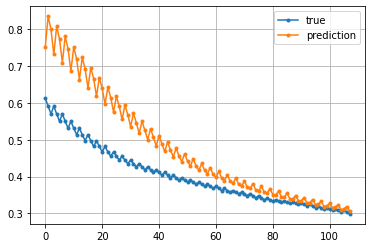

TEST FR-A
MSE =  0.0019884367810275344
MAE =  0.04080263202692437


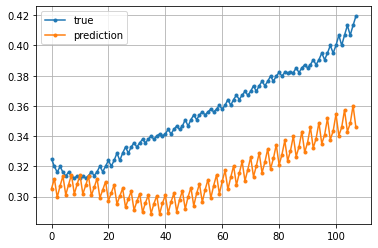

TEST FR-B
MSE =  0.004452593051070191
MAE =  0.05228916537921458


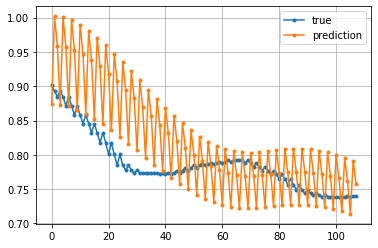

TEST FR-C
MSE =  0.0061505203974830565
MAE =  0.06349339280116613


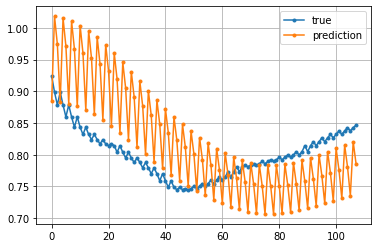

TEST FR-J
MSE =  0.0004949037713026602
MAE =  0.01920835343676653


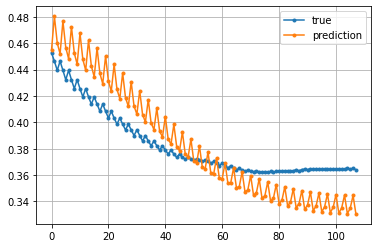

In [29]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true', marker=".")
    plt.plot(yp.reshape(-1), label='prediction', marker=".")
    plt.legend()
    plt.grid()
    plt.show()

In [30]:
def error_set(models, points, plot=False, mode='train'):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

### Let's use the validation set

In [31]:
def run_model(x_train, y_train, x_val, y_val, p):
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=True, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=False, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(Dense(n_forecast, kernel_regularizer=p['reg'](p['regw']), 
                        activation=p['activation']))
    LSTMModel = model
    
    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mae', 'mse'])
    history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=p["epochs"], 
                        verbose=0, shuffle=False, 
                        validation_data=validation_generator(), validation_steps=len(valid_datapoints))
    
    return history, model

p = {'activation':['relu', 'elu', 'sigmoid'],
     'reg': [lambda x: regularizers.l2(l=x), lambda x: regularizers.l1(l=x), lambda x: None],
     'regw': [1e-4, 5e-4, 1e-3],
     'optimizer': ['Adam'],
     'losses': ['mae', 'mse'],
     'epochs': [10, 20],
     'dropout': [0, 0.2, 0.4],
     'recurrent_dropout': [0, 0.2, 0.4]
}

scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=p,
    model=run_model,
    experiment_name='trends1', 
    fraction_limit=0.01
)

100%|██████████| 9/9 [00:50<00:00,  5.66s/it]


In [32]:
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

MAE 0.034743960946798325
MSE 0.006334942299872637
VAL MAE 0.09096643328666687
VAL MSE 0.01673121750354767


,end,dropout,epochs,losses,reg,duration,val_mae,val_loss,activation,mse,start,regw,val_mse,optimizer,loss,round_epochs,recurrent_dropout,mae
0,01/25/21-175313,0.4,20,mse,<function <lambda> at 0x7f2e7830bca0>,6.840917,0.090966,0.020979,elu,0.010436,01/25/21-175306,0.0001,0.016731,Adam,0.014720,20,0.2,0.066116
6,01/25/21-175346,0.0,10,mse,<function <lambda> at 0x7f2e782f8ee0>,3.126130,0.112746,0.054971,relu,0.007204,01/25/21-175343,0.0001,0.022346,Adam,0.040437,10,0.0,0.051823
8,01/25/21-175357,0.0,20,mae,<function <lambda> at 0x7f2e7830bca0>,4.404804,0.114125,0.118496,elu,0.006335,01/25/21-175352,0.0001,0.023297,Adam,0.039146,20,0.0,0.034744
7,01/25/21-175352,0.4,20,mae,<function <lambda> at 0x7f2e782f8ee0>,5.586217,0.119899,0.209558,elu,0.013430,01/25/21-175346,0.0005,0.025764,Adam,0.158923,20,0.0,0.066453
2,01/25/21-175324,0.4,20,mae,<function <lambda> at 0x7f2e782f8ee0>,5.401290,0.118962,0.274026,relu,0.014378,01/25/21-175319,0.0010,0.026467,Adam,0.225196,20,0.2,0.064340
3,01/25/21-175330,0.2,10,mae,<function <lambda> at 0x7f2e782f8b80>,5.806514,0.128595,0.128595,relu,0.010353,01/25/21-175324,0.0001,0.029653,Adam,0.052697,10,0.2,0.052697
4,01/25/21-175337,0.0,10,mae,<function <lambda> at 0x7f2e782f8b80>,6.985183,0.144541,0.144541,sigmoid,0.015988,01/25/21-175330,0.0001,0.033330,Adam,0.075350,10,0.2,0.075350
5,01/25/21-175343,0.0,20,mae,<function <lambda> at 0x7f2e782f8ee0>,5.116668,0.178174,0.327599,sigmoid,0.018236,01/25/21-175338,0.0010,0.053247,Adam,0.233001,20,0.4,0.077466
1,01/25/21-175318,0.4,10,mae,<function <lambda> at 0x7f2e782f8ee0>,5.346628,0.184533,0.324413,sigmoid,0.040262,01/25/21-175313,0.0005,0.061259,Adam,0.271011,10,0.2,0.127775


BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3)
Model,,,,,,
LSTM tuned,0.003237,0.042157,0.003284,0.042699,0.004085,0.047498


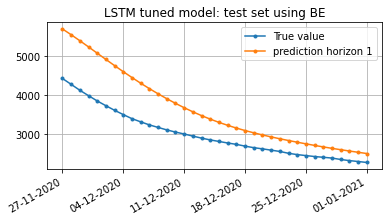

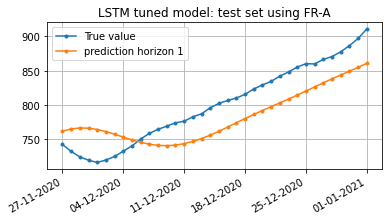

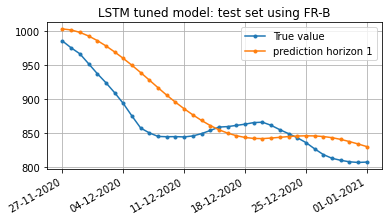

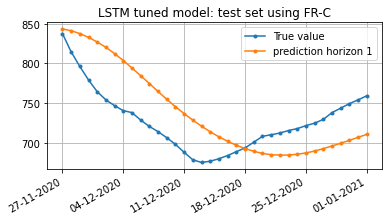

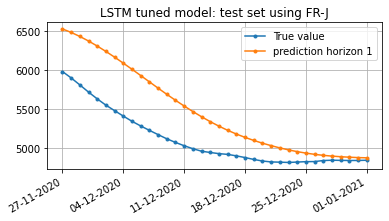

In [33]:
best_model = scan_object.best_model('val_mse', asc=True)
error_set({'LSTM tuned': best_model}, test_datapoints, plot=True, mode='test')

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [34]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat target n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [35]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, target)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [36]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [37]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0401 - mean_absolute_error: 0.1164 - val_loss: 0.0639 - val_mean_absolute_error: 0.1757
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0293 - mean_absolute_error: 0.0965 - val_loss: 0.0524 - val_mean_absolute_error: 0.1583
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0231 - mean_absolute_error: 0.0836 - val_loss: 0.0439 - val_mean_absolute_error: 0.1443
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0184 - mean_absolute_error: 0.0734 - val_loss: 0.0371 - val_mean_absolute_error: 0.1318
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0148 - mean_absolute_error: 0.0650 - val_loss: 0.0315 - val_mean_absolute_error: 0.1205
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_absolute_error: 0.0578 - val_loss: 0.0269 - val_mean_absolute_error: 0.1103
Epoch 7/10
5/5 [=======================

# Comparisons of the models

In [43]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=False, mode='train', rescale=True):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :param rescale: whether to compute the error according to the rescaled data or not
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        if rescale:
            y_true_horizon = np.array([mapper(l[:,i].reshape(-1), loc) for loc, l in y_true.items()]).reshape(-1)
        else:
            y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            if rescale:
                y_predicted_horizon = np.array([mapper(l[:,i], loc) for loc, l in y_predicted[k].items()]).reshape(-1)
            else:
                y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

## Training

BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3)
Model,,,,,,
RepeatLast,6172.305934,32.224587,22776.502134,63.096268,47405.124474,92.232108
Linear regression,24304.140988,52.607012,45385.201152,71.837791,75849.510386,93.452216
Dense,91013.889299,110.506031,321990.124419,280.498065,804151.395860,284.781224
LSTM,541984.891444,265.068219,629376.444797,314.488686,681345.417783,303.060297


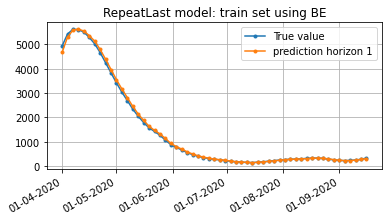

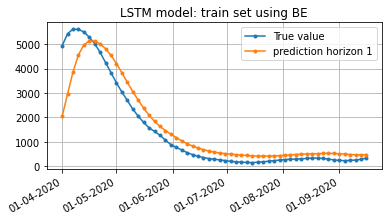

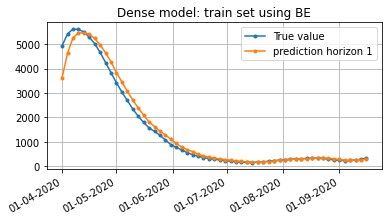

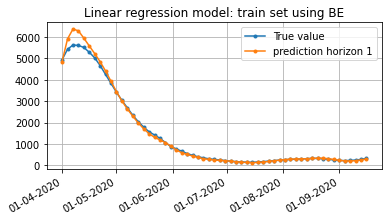

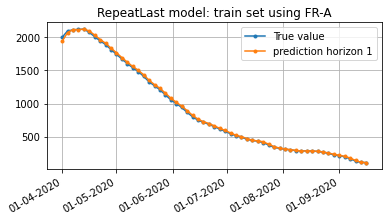

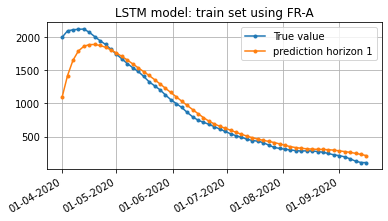

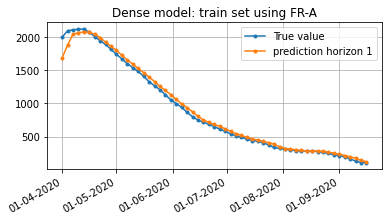

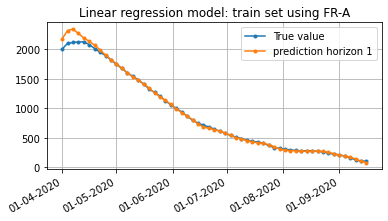

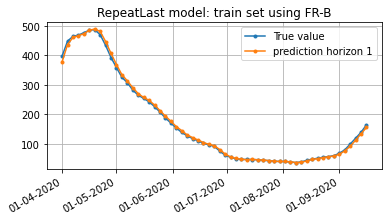

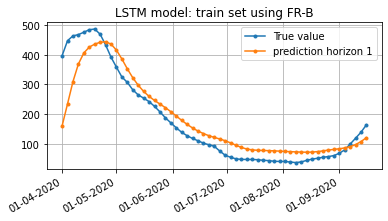

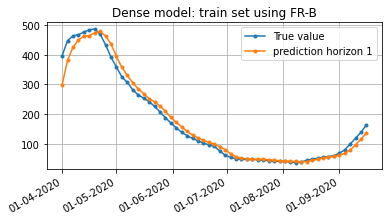

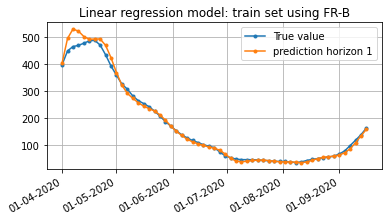

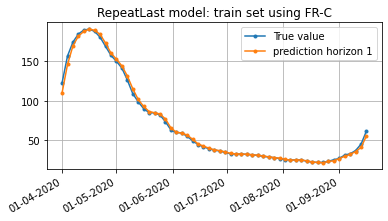

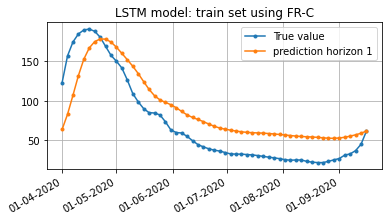

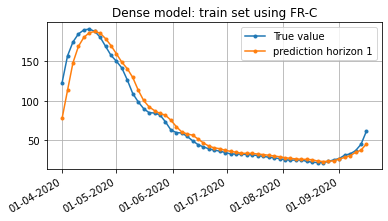

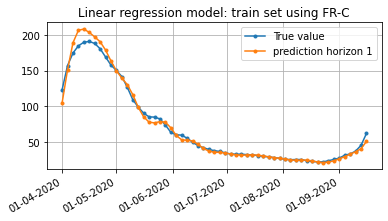

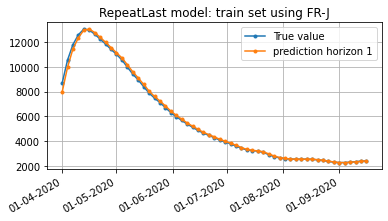

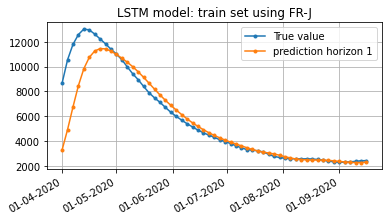

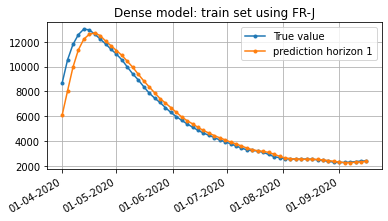

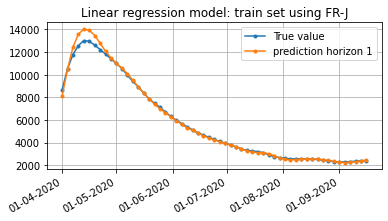

In [44]:
error_set(all_models, train_datapoints, plot=True, mode='train')

## Validation

BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3)
Model,,,,,,
RepeatLast,0.000268,0.011695,0.001071,0.023405,0.002407,0.035135
Linear regression,0.000815,0.020440,0.001562,0.028342,0.002663,0.037037
Dense,0.003548,0.041984,0.007392,0.064118,0.035226,0.132133
LSTM,0.019104,0.099314,0.019087,0.099392,0.025274,0.115090


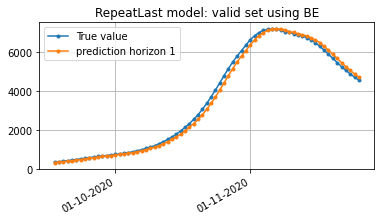

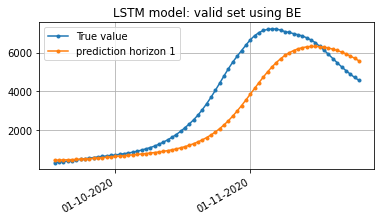

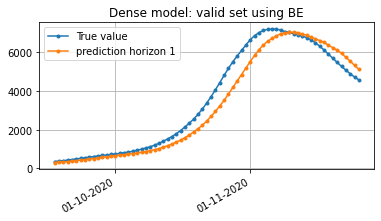

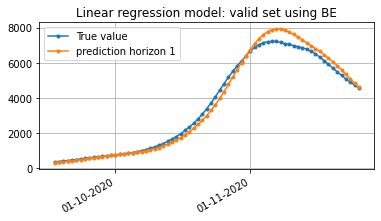

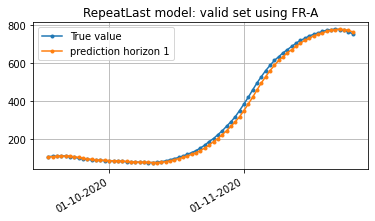

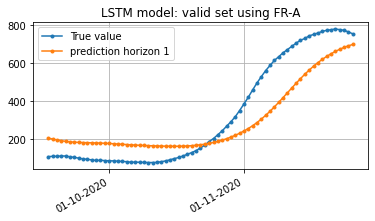

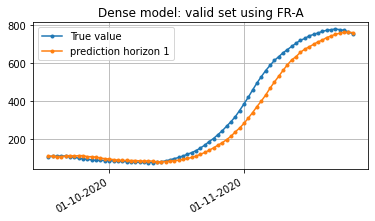

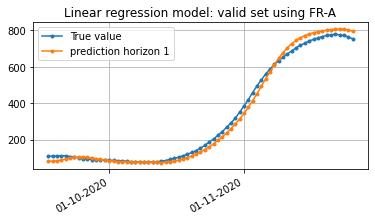

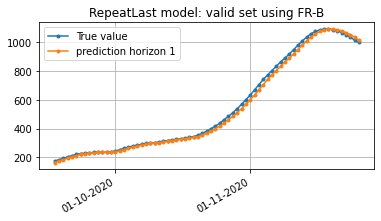

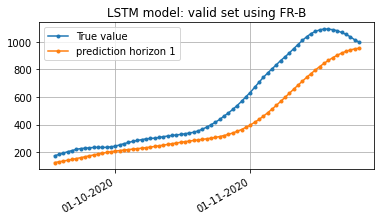

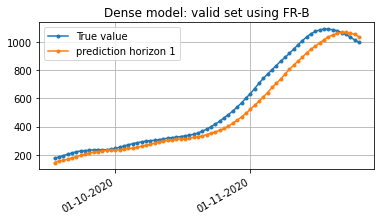

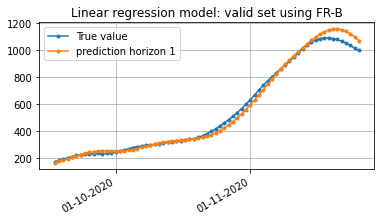

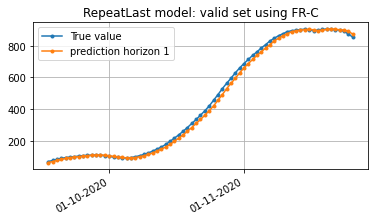

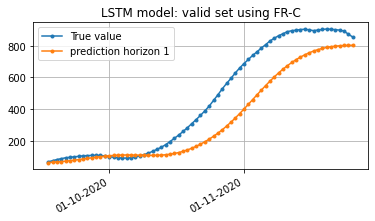

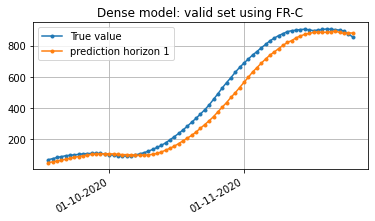

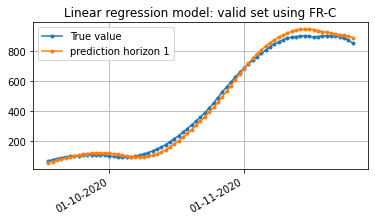

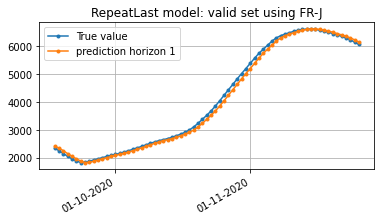

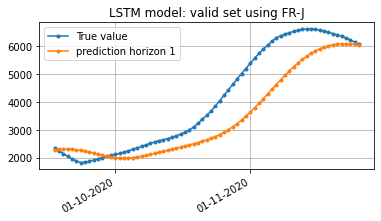

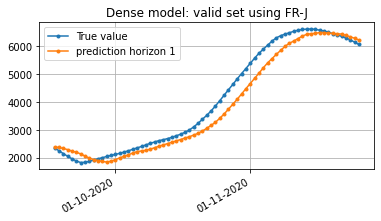

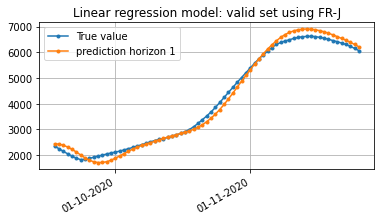

In [40]:
error_set(all_models, valid_datapoints, plot=True, mode='valid')

## Test

BE
FR-A
FR-B
FR-C
FR-J


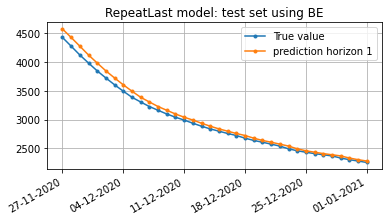

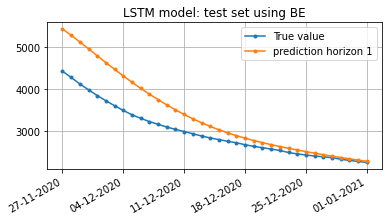

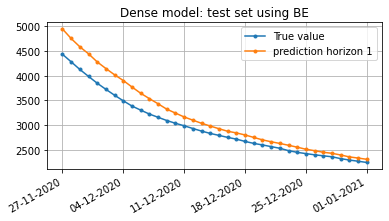

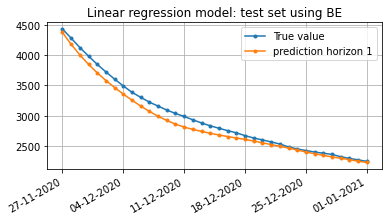

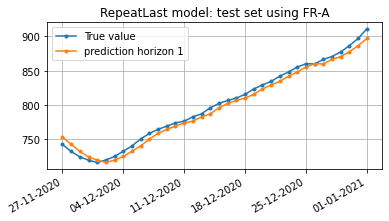

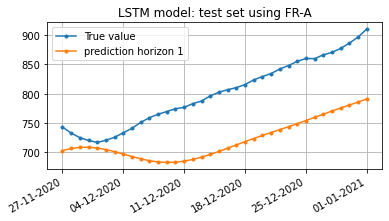

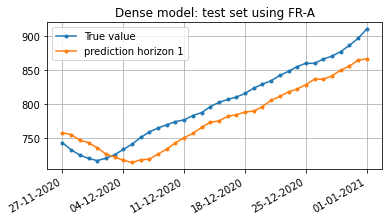

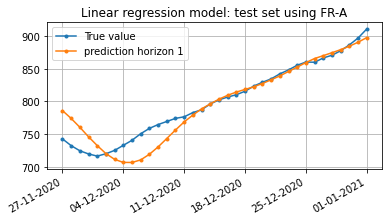

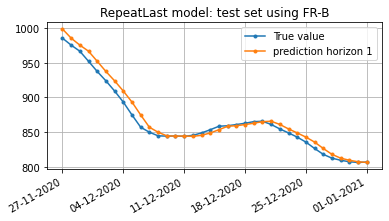

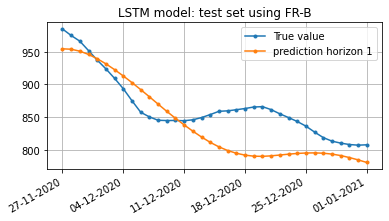

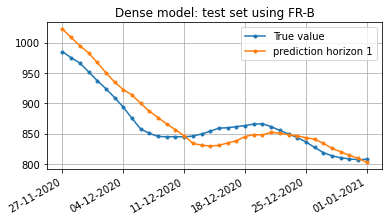

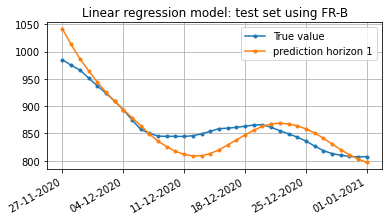

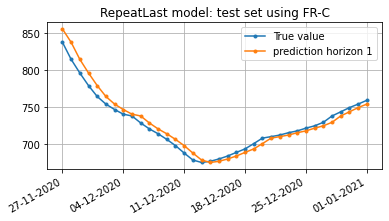

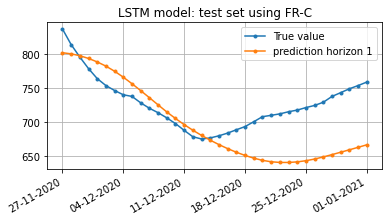

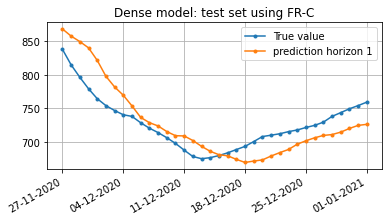

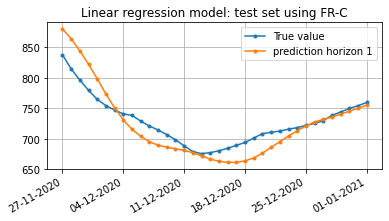

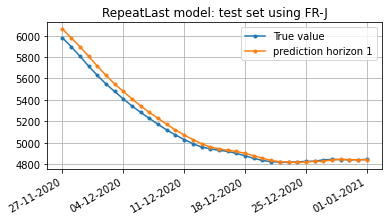

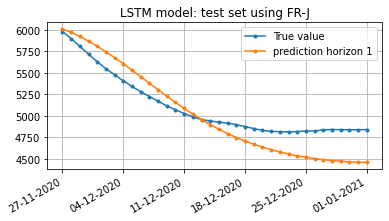

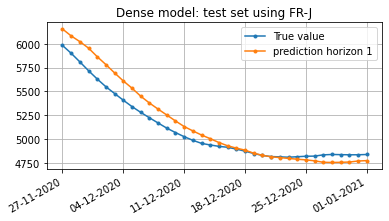

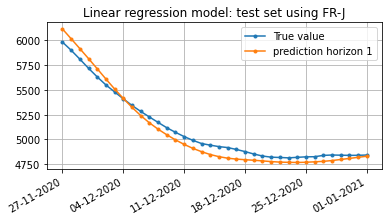

In [41]:
df = error_set(all_models, test_datapoints, plot=True, mode='test')

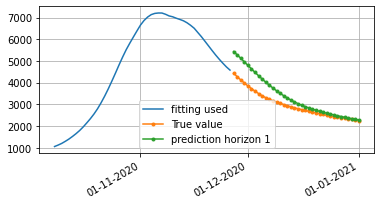

In [42]:
idx = test_idx
x = test_datapoints['BE'][0]
yp = LSTMModel.predict(x)
plot_prediction_vs_actual(yp, idx, 'BE', show_fit=50)